In [63]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import mysql.connector
import numpy as np
import math
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import mixture
%matplotlib inline

In [91]:
############ CONNECT TO THE DATABASE - OSX/Windows ############
# connection = pymysql.connect(host='localhost',
#                              user='root',
#                              password='root',#put your password for mysql server here.
#                              db='yelp_db',
#                              charset='utf8mb4',
#                              cursorclass=pymysql.cursors.DictCursor)

############ CONNECT TO THE DATABASE - RHEL ############
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    port=3306,
    database='yelp_db')

data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.city,
  business.neighborhood,
  category.category
  FROM category
  inner join business on
  business.id = category.business_id
  WHERE business.city ="Pittsburgh"
  and neighborhood IS NOT NULL
  and category.category = "Italian"
  or category.category = "Chinese"
  or category.category = "Mexican"
  or category.category = "American (New)"
  or category.category = "Korean"
  or category.category = "Japanese"
  or category.category = "Thai"
  or category.category = "Indian"
  GROUP BY business.id, category.category''',connection) #.values


# or category.category = "Mediterranean"
#   or category.category = "Greek"
#   or category.category = "French"
# or category.category = "Turkish"
#   or category.category = "Caribbean"
#   or category.category = "Vietnamese"
#   or category.category = "Latin American"
#   or category.category = "Taiwanese"

In [92]:
#### CLUSTERING BY NEIGHBORHOOD
sample1 = data[['latitude','longitude','city','neighborhood','category']]
sample1 = sample1.loc[sample1['city'] == 'Pittsburgh']
sample1 = sample1[['latitude','longitude','neighborhood','category']]

cuisines = ['Italian','Chinese',"Mexican","American (New)","Mediterranean", "Japanese","Thai","Indian","Middle Eastern",
            "Greek","French","Korean", "Turkish","Caribbean","Vietnamese","Latin American","Taiwanese"]
#sample1

In [93]:
# remove all restaurants that aren't within a neighborhood
sample1['neighborhood'].replace('','NaN',inplace=True)
sample1 = sample1[sample1.neighborhood != 'NaN']

In [94]:
#sample1

In [95]:
# drop everything but downtown
sample2 = sample1[sample1.neighborhood == 'Downtown']
#sample2
# now drop the neighborhood
sample2.drop('neighborhood', 1, inplace=True)

In [96]:
# now drop the neighborhoods for sample 1
sample1.drop('neighborhood', 1, inplace=True)
#sample1

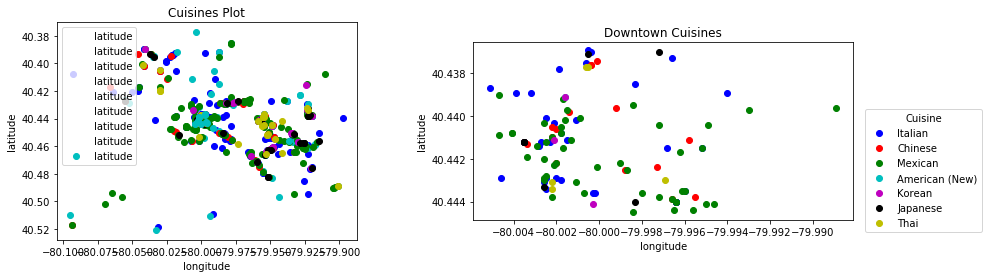

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(15)

# Plot Sample1
gp = sample1.groupby('category')
gp.get_group('Italian').plot(x='longitude', y='latitude', style='bo', ax=ax1)
gp.get_group('Chinese').plot(x='longitude', y='latitude', style='co', ax=ax1)
gp.get_group('Mexican').plot(x='longitude', y='latitude', style='ro', ax=ax1)
gp.get_group('American (New)').plot(x='longitude', y='latitude', style='go', ax=ax1)
gp.get_group('Korean').plot(x='longitude', y='latitude', style='co', ax=ax1)
gp.get_group('Japanese').plot(x='longitude', y='latitude', style='mo', ax=ax1)
gp.get_group('Thai').plot(x='longitude', y='latitude', style='ko', ax=ax1)
gp.get_group('Indian').plot(x='longitude', y='latitude', style='yo', ax=ax1)


ax1.set_title('Cuisines Plot')
ax1.set_xlabel('longitude'); ax1.set_ylabel('latitude')
ax1.set_xlim(0,100); ax1.set_ylim(100,0)
ax1.axis('image')

# Plot Sample2
gp = sample2.groupby('category')

gp.get_group('Italian').plot(x='longitude', y='latitude', style='bo', ax=ax2)
gp.get_group('Chinese').plot(x='longitude', y='latitude', style='co', ax=ax1)
gp.get_group('Mexican').plot(x='longitude', y='latitude', style='ro', ax=ax2)
gp.get_group('American (New)').plot(x='longitude', y='latitude', style='go', ax=ax2)
gp.get_group('Korean').plot(x='longitude', y='latitude', style='co', ax=ax2)
gp.get_group('Japanese').plot(x='longitude', y='latitude', style='mo', ax=ax2)
gp.get_group('Thai').plot(x='longitude', y='latitude', style='ko', ax=ax2)
gp.get_group('Indian').plot(x='longitude', y='latitude', style='yo', ax=ax2)

ax2.set_title('Downtown Cuisines')
ax2.set_xlabel('longitude'); ax2.set_ylabel('latitude')
ax2.set_xlim(0,50); ax2.set_ylim(50,0)
ax2.axis('image')
plt.legend(['Italian','Chinese','Mexican','American (New)', 'Korean',
           'Japanese','Thai','Indian'], bbox_to_anchor=(1.35,0.65), title='Cuisine')
plt.show()

In [75]:
#replace all of the categories with numerials
sample1['category'].replace('Italian',0,inplace=True)
sample1['category'].replace('Chinese',1, inplace=True)
sample1['category'].replace('Mexican',2, inplace=True)
sample1['category'].replace('American (New)',3, inplace=True)
sample1['category'].replace('Korean',4, inplace=True)
sample1['category'].replace('Japanese',5, inplace=True)
sample1['category'].replace('Thai',6, inplace=True)
sample1['category'].replace('Indian',7, inplace=True)

# feature normalization

def normalize(data):
    data['longitude'] = (data.longitude - data.longitude.min()) / (data.longitude.max() - data.longitude.min())
    data['latitude'] = (data.latitude - data.latitude.min()) / (data.latitude.max() - data.latitude.min())
    #data['Type'] = 0
    #data['Type'][data.Sublattice == 'B'] = 1

normalize(sample1)
normalize(sample2)
sample1

,latitude,longitude,category
1,0.585485,0.743421,0
2,0.585485,0.743421,2
56,0.395673,0.870445,6
149,0.450803,0.467611,3
217,0.448709,0.500000,3
223,0.429170,0.511134,0
226,0.685973,0.883097,5
237,0.683880,0.887146,0
238,0.472435,0.589575,0
282,0.831821,0.188765,3
